In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
import argparse
from src.solver import TASKS
from src.core import YAMLConfig

config = '/workspace/chanyoung/code/MODU/configs/NeXt-DETR_lulu/tiny_kiosk.yml'
pt_path = '/workspace/chanyoung/code/MODU/output/lulu/kiosk/tiny_250411/best.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
print(solver)

In [3]:
device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()
postprocessor = solver.postprocessor
print(postprocessor)

_IncompatibleKeys(missing_keys=['norm0.weight', 'norm0.bias', 'norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['head.bias', 'head.weight', 'norm.bias', 'norm.weight'])
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
resume from /workspace/chanyoung/code/MODU/output/lulu/kiosk/tiny_250411/best.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict
DETRPostProcessor(use_focal_loss=True, num_classes=2, num_top_queries=300)


In [4]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def visualize_all_objects_above_threshold(post_output, image_path, target_size=(640, 640), score_threshold=0.5):
    labels = post_output['labels'].detach().cpu().numpy()
    boxes = post_output['boxes'].detach().cpu().numpy()
    scores = post_output['scores'].detach().cpu().numpy()

    # 이미지 로드 및 리사이즈
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    H, W = target_size

    for idx in range(len(scores)):
        if scores[idx] < score_threshold:
            continue
        label = labels[idx]
        box = boxes[idx]
        score = scores[idx]


        # 바운딩 박스 좌표
        x1, y1, x2, y2 = map(int, box)

        # 클래스별 색상 정의
        if label == 1:
            color = (255, 0, 0)  # 빨강
        elif label == 2:
            color = (0, 0, 255)  # 파랑
        else:
            color = (0, 255, 0)  # 예외 클래스는 초록 (혹시 모를 경우)

        # 마스크 영역 시각화
        color_overlay = np.array(color, dtype=np.uint8)

        # 바운딩 박스와 텍스트
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        print(x1,y1,x2,y2)
        # cv2.putText(image, f"Class: {label}, Score: {score:.2f}", (x1, y1 - 10),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [15]:
import json
import os

def get_image_names(json_file):
    # COCO JSON 파일 로드
    with open(json_file, 'r') as f:
        coco_data = json.load(f)
    
    # 이미지 이름 리스트 추출
    image_names = [image['file_name'] for image in coco_data['images']]
    return image_names

# 사용 예시
json_file = '/workspace/chanyoung/data/cropped/kiosk/coco_kiosk_base_instance_seg_channel_val.json'
image_names = get_image_names(json_file)
i=0

/workspace/chanyoung/data/cropped/kiosk/images/0003_gM_018_S20_cR_ltH_F_S_pF.png
295 359 326 372
618 281 630 289
280 134 295 139
69 163 77 167
267 444 282 450
552 295 568 302
104 352 130 360
355 454 364 459
569 249 579 254
175 146 187 149
435 162 447 165
501 302 509 306
431 139 452 146
378 100 395 107
154 331 171 338
472 358 482 362
449 409 459 413
192 375 203 381
209 445 220 450
128 400 141 405
356 190 367 194
465 438 476 443
262 361 280 369
306 111 332 116
35 335 45 342
395 467 401 470
548 132 563 138
249 204 258 208
544 277 556 282
260 138 274 143
249 204 258 208
158 387 169 391


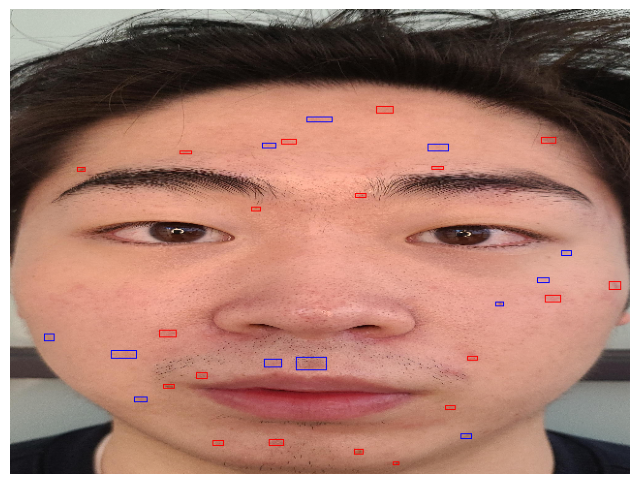

In [18]:
img_path = os.path.join('/workspace/chanyoung/data/cropped/kiosk/images', image_names[i])
print(img_path)
image = Image.open(img_path)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 480)),
    torchvision.transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

output = model(input_tensor)
# print(output)
post_output = postprocessor(output, torch.tensor([[640, 480]]).to(input_tensor.device))
# 시각화: score 0.5 이상 객체 전부
visualize_all_objects_above_threshold(post_output[0], img_path, target_size=(640, 480), score_threshold=0.5)

i+=1
